<a href="https://colab.research.google.com/github/fatimaAlzahraa1/graduation/blob/main/vision_transformer_xray_pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision Transformers (ViT)

Binary Image Classification of chest X-ray images. The dataset consists of a binary labeled Chest Ray Images (https://pubmed.ncbi.nlm.nih.gov/29474911/). This data consists of two pneumonia diseases, bacterial and viral, both labeled PNEUMONIA, augmented with images labeled as NORMAL.




In [ ]:
#ViT = Vision Transformer
#وهو نموذج بيعتمد على فكرة الـ Transformer (اللي ظهر لأول مرة في الـ NLP مع BERT وGPT) بس بيطبقه على الصور بدل النصوص.
#بدل ما نستخدم فلاتر الـ CNN لاستخراج الميزات من الصورة، ViT بيحول الصورة لسلسلة "patches" صغيرة، ويتعامل معاها كأنها "كلمات" في جملة.

# تقطيع الصورة إلى باتشات (Patches)
# 2. تحويل كل باتش إلى تمثيل عددي (Embedding)
# 3. إضافة موقع كل باتش (Positional Encoding)
#تمرير السلسلة إلى Transformer Encoder
# 5. استخدام الـ [CLS] Token
#6. طبقة الإخراج (Classifier)



In [1]:

import tensorflow as tf
print(tf.__version__)


2.15.0


In [1]:
!pip install tensorflow==2.15.0 --no-deps

In [2]:
!pip install tensorflow-addons==0.22.0 --no-deps

## Environment Setup

In [3]:
!pip install --upgrade wandb==0.16.6
!pip install wandb[keras]  # Add this line to ensure keras integration

import wandb
from wandb.keras import WandbCallback


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa


import pandas as pd
import json
import zipfile
import os
import seaborn as sns
import random
import shutil
import time

from PIL import Image
from matplotlib import pyplot as plt

from keras.models import Sequential, Model

from tensorflow.keras.applications import InceptionV3, Xception, InceptionResNetV2, ResNet50
from tensorflow.keras.applications.resnet import preprocess_input

from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard


!mkdir output
!mkdir output/tmp-augmented-images/

random.seed(123)

mkdir: cannot create directory ‘output’: File exists
mkdir: cannot create directory ‘output/tmp-augmented-images/’: File exists


## Dataset

In [6]:
# You need to insert your own API key below to run the code

kaggle = {
    "username": "<your-kaggle-username>",
    "api_key": "<your-kaggle-api-key>",
    "on_kernel": False,
    "dataset": {
        "sample": "-",
        "full": "paultimothymooney/chest-xray-pneumonia"
        }
}

if kaggle["on_kernel"]:
  path_prefix = '/kaggle/working/'
else:
  path_prefix = '/content/'

# Download dataset
def download_dataset(which_dataset):
  data = {"username": kaggle["username"],"key": kaggle["api_key"]}
  with open('kaggle.json', 'w') as json_file:
      json.dump(data, json_file)

  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json
  kaggle_dataset = kaggle["dataset"][which_dataset]
  !kaggle datasets download -d $kaggle_dataset

  # Paths neeeds to be changed manually because of different directory structures, check with !ls
  if not os.path.isdir('dataset'):
    print("Unzipping... ")
    zip_ref = zipfile.ZipFile('chest-xray-pneumonia.zip', 'r')
    zip_ref.extractall('dataset')
    zip_ref.close()
    !rm -rf /content/dataset/chest_xray/chest_xray
    !rm -rf /content/dataset/chest_xray/__MACOSX
    !rm -rf /content/chest-xray-pneumonia.zip


  #!ls Data


download_dataset("full")

data_files = os.listdir("dataset/chest_xray")
print(data_files)

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
Unzipping... 
['val', 'train', 'test']


In [7]:
def resample_data(move_from, move_to, cl, images_to_move=100):
  path = path_prefix + 'dataset/chest_xray/'

  classes = os.listdir(path + move_from)

  cl += '/'
  curr_path = path + move_from + cl
  for _, _, files in os.walk(curr_path):
    random.shuffle(files)
    files_to_move = files[:images_to_move]
    for fn in files_to_move:
      shutil.move(curr_path + fn, path + move_to + cl + fn)
      #print('Moved ' + curr_path + fn)

  print('Resampled Images')

move_from, move_to = 'train/', 'val/'
#resample_data(move_from, move_to, 'PNEUMONIA', 2534)



# Training images
print('Number of NORMAL training images:')
!ls /content/dataset/chest_xray/train/NORMAL/ | wc -l
print('Number of PNEUMONIA training images:')
!ls /content/dataset/chest_xray/train/PNEUMONIA/ | wc -l
print()


# Test images
#resample_data('test/', 'val/', 'PNEUMONIA', 2690)
print('Number of NORMAL test images:')
!ls /content/dataset/chest_xray/test/NORMAL/ | wc -l
print('Number of PNEUMONIA test images:')
!ls /content/dataset/chest_xray/test/PNEUMONIA/ | wc -l

Number of NORMAL training images:
1341
Number of PNEUMONIA training images:
3875

Number of NORMAL test images:
234
Number of PNEUMONIA test images:
390


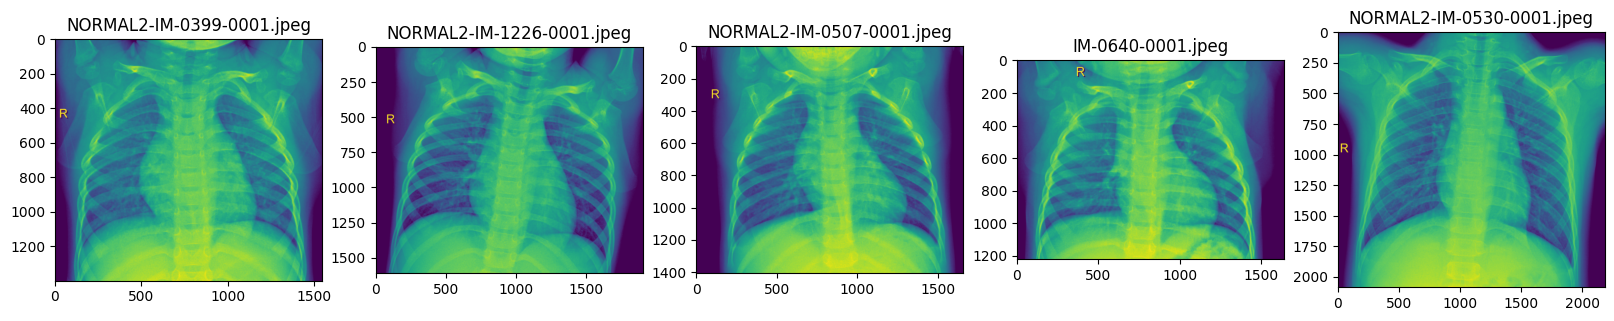

In [8]:
def viewImagesFromDir(path, num=5):
  #Display num random images from dataset. Rerun cell for new random images. The images are only single-channel

  img_paths_visualise = sorted(
        os.path.join(path, fname)
        for fname in os.listdir(path)
        if fname.endswith(".jpeg")
  )

  random.shuffle(img_paths_visualise)

  fig, ax = plt.subplots(1, num, figsize=(20, 10))

  for i in range(num):
    ax[i].imshow(Image.open(img_paths_visualise[i]))
    index = img_paths_visualise[i].rfind('/') + 1
    ax[i].title.set_text(img_paths_visualise[i][index:])

  fig.canvas.draw()
  time.sleep(1)

viewImagesFromDir('/content/dataset/chest_xray/train/NORMAL/', num=5)

# Prepare the data

## Configure the hyperparameters

In [9]:
CLASSES = os.listdir('/content/dataset/chest_xray/train')
TRAINING_DATA_SET_PATH = '/content/dataset/chest_xray/train'
TEST_DATA_SET_PATH = '/content/dataset/chest_xray/test'

params = dict(
    seed = 123,
    image_dim = (288,288),
    weight_decay = 1e-4,
    epochs = 30,
    batch_size = 16,
    patch_size = 18,
    pool_size = (2,2),
    optimizer = 'Adam',
    l_rate = 0.001,
    val_split = .15,
    use_transfer_learning = False,
    use_data_aug = False,

    l2_reg = .0,
    projection_dim = 16,
    num_heads = 4,

    # Size of the transformer layers
    transformer_layers = 4,
    num_classes = len(CLASSES),
    mlp_head_units = [1024,512]

    )

new_params = dict(
    num_patches = (params['image_dim'][0] // params['patch_size']) ** 2,
    transformer_units = [
    params['projection_dim'] * 2,
    params['projection_dim']],
    input_shape = (params['image_dim'][0], params['image_dim'][1], 3),

)
params.update(new_params)


if params['use_data_aug']:
  data_aug_params = dict(
      da_rotation = 20,
      da_w_shift = 0.1,
      da_h_shift = 0.1,
      da_shear = 0.05,
      da_zoom = 0.05,
      da_h_flip = False,
      da_v_flip = False,
  )

  params.update(data_aug_params)


# Ability to switch amount of channel to utilise pre-trained models with specific input shapes
if params['use_transfer_learning']:
  INPUT_SHAPE = (params['image_dim'][0], params['image_dim'][1], 3)
  COLOUR_MODE = 'rgb'
else:
  INPUT_SHAPE = (params['image_dim'][0], params['image_dim'][1], 3)
  COLOUR_MODE = 'rgb'

if params['use_data_aug']:
  datagen = ImageDataGenerator(validation_split=params['val_split'], rescale=1./255,
                               rotation_range=params['da_rotation'],
                               width_shift_range=params['da_w_shift'],
                               height_shift_range=params['da_h_shift'],
                               shear_range=params['da_shear'],
                               zoom_range=params['da_zoom'],
                               horizontal_flip=params['da_h_flip'],
                               vertical_flip=params['da_v_flip'],
                               fill_mode="constant",
                               cval=0
                               )
else:
  datagen = ImageDataGenerator(validation_split=params['val_split'])

# Read all training and validation data into variables from directory.
# Due to faulty quality of the given validation-set images, all images are taken from the training folder
train_generator = datagen.flow_from_directory(TRAINING_DATA_SET_PATH,
                                                    batch_size=params['batch_size'],
                                                    seed=123,
                                                    class_mode="categorical",
                                                    classes=CLASSES,
                                                    target_size=params['image_dim'],
                                                    color_mode=COLOUR_MODE,
                                                    subset='training',
                                                    shuffle=True)

val_datagen = ImageDataGenerator(validation_split=0.15, rescale=1./255)
valid_generator = datagen.flow_from_directory(TRAINING_DATA_SET_PATH,
                                                    batch_size=params['batch_size'],
                                                    seed=123,
                                                    class_mode="categorical",
                                                    classes=CLASSES,
                                                    target_size=params['image_dim'],
                                                    color_mode=COLOUR_MODE,
                                                    subset='validation',
                                                    shuffle=False)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(TEST_DATA_SET_PATH,
                                                    batch_size=params['batch_size'],
                                                    seed=123,
                                                    class_mode="categorical",
                                                    classes=CLASSES,
                                                    target_size=params['image_dim'],
                                                    color_mode=COLOUR_MODE,
                                                    shuffle=False)


Found 4434 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Custom Layers

The following cells uses inspiration from Khalid Salamas and the  [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929) paper from Google Research on Vision Transformers.

In [10]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


# Linearly transform patches by projecting it into a
# vector of size `projection_dim` and also adds a learnable position
# embedding to the projected vector.
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

Image size: 288 X 288
Patch size: 18 X 18
Patches per image: 256
Elements per patch: 972


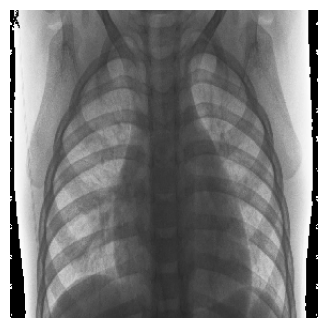

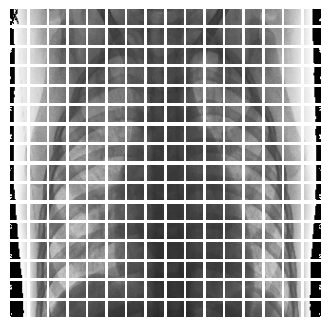

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image, label = iter(next(train_generator))
image = image[0]*255.
#image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow((image).astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(params['image_dim'][0], params['image_dim'][0])
)
patches = Patches(params['patch_size'])(resized_image)
print(f"Image size: {params['image_dim'][0]} X {params['image_dim'][0]}")
print(f"Patch size: {params['patch_size']} X {params['patch_size']}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (params['patch_size'], params['patch_size'], 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Generate ViT model

In [12]:
def create_vit_classifier():
    inputs = layers.Input(shape=params['input_shape'])
    # Create patches.
    patches = Patches(params['patch_size'])(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(params['num_patches'], params['projection_dim'])(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(params['transformer_layers']):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=params['num_heads'], key_dim=params['projection_dim'], dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=params['transformer_units'], dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=params['mlp_head_units'], dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(len(CLASSES))(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Train Model

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/chest_xray/train", # Changed to match previous data loading
    label_mode="int",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Similarly, change "data/val" to the correct validation directory path
val_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/chest_xray/val", # Changed to match previous data loading
    label_mode="int",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# تحسين الأداء
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# طبقة تقسيم الصورة إلى patches
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# طبقة تشفير الـ patches
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=tf.shape(patch)[1], delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# بناء نموذج ViT بسيط
def create_vit_classifier():
    patch_size = 16
    num_patches = (IMAGE_SIZE // patch_size) ** 2
    projection_dim = 64
    transformer_layers = 8
    num_heads = 4
    transformer_units = [projection_dim * 2, projection_dim]
    mlp_head_units = [128, 64]

    inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = Patches(patch_size)(inputs)
    x = PatchEncoder(num_patches, projection_dim)(x)

    for _ in range(transformer_layers):
        # Normalization and Attention
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x1, x1)
        x2 = layers.Add()([attention_output, x])

        # Feed Forward
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        mlp = keras.Sequential([
            layers.Dense(units=transformer_units[0], activation='gelu'),
            layers.Dense(units=transformer_units[1]),
        ])
        x = layers.Add()([mlp(x3), x2])

    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    for units in mlp_head_units:
        x = layers.Dense(units, activation='relu')(x)
        x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# تشغيل التدريب
def run_experiment(model):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)
    return history, model

model = create_vit_classifier()
history, model = run_experiment(model)


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Epoch 1/10
163/163 [==============================] - 340s 2s/step - loss: 0.5833 - accuracy: 0.7291 - val_loss: 0.8305 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 326s 2s/step - loss: 0.5661 - accuracy: 0.7414 - val_loss: 0.8217 - val_accuracy: 0.5000
Epoch 3/10
163/163 [==============================] - 329s 2s/step - loss: 0.5561 - accuracy: 0.7425 - val_loss: 0.7532 - val_accuracy: 0.5000
Epoch 4/10
163/163 [==============================] - 325s 2s/step - loss: 0.5371 - accuracy: 0.7442 - val_loss: 0.6961 - val_accuracy: 0.5625
Epoch 5/10
163/163 [==============================] - 315s 2s/step - loss: 0.4687 - accuracy: 0.7834 - val_loss: 0.6045 - val_accuracy: 0.6875
Epoch 6/10
163/163 [==============================] - 315s 2s/step - loss: 0.4052 - accuracy: 0.8275 - val_loss: 1.0474 - val_accuracy: 0.5625
Epoch 7/10
163/163 [==============================] - 320s 2s/

In [25]:
# حفظ النموذج في ملف
model.save("pneumonia_vit_model.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
